In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem,PandasTools, Descriptors, Draw
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rdkit.Chem import MACCSkeys
import rdkit.Chem.Descriptors as Descriptors
import torch.nn as nn
import torch
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
import pandas as pd

In [4]:
df = pd.read_csv("data/new.csv", names=["Name","year","compound", "Smiles"], header=None,sep=";")
df

,Name,year,compound,Smiles
0,Gefitinib,2003,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
1,Erlotinib,2004,CHEMBL553,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
2,Lapatinib,2007,CHEMBL554,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...
3,Afatinib,2013,CHEMBL1173655,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...
4,Osmertinib,2015,CHEMBL3353410,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...


In [5]:
df.columns

Index(['Name', 'year', 'compound', 'Smiles'], dtype='object')

In [6]:
smiles = df.Smiles.tolist() # convert to list
names = df.Name.tolist() # convert to list

print(smiles[0], names[0])# print first smiles and name

COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1 Gefitinib


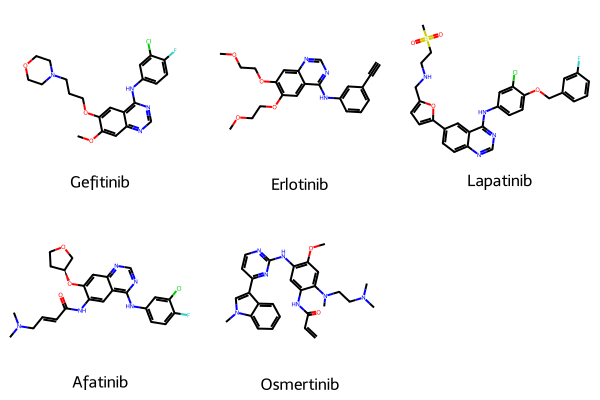

In [7]:
molecules = [Chem.MolFromSmiles(s) for s in smiles]# convert smiles to molecules
Draw.MolsToGridImage(molecules, legends=names)# draw molecules

In [8]:

# Convert SMILES to RDKit Molecule objects
molecules = [Chem.MolFromSmiles(s) for s in smiles]

# Calculate MACCS Keys fingerprints
maccs_fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules]


In [9]:
# Create a similarity table
maccs_table = pd.DataFrame(index=names, columns=names)

for i in range(len(molecules)):
    for j in range(len(molecules)):
        if molecules[i] is not None and molecules[j] is not None:
            fp1 = MACCSkeys.GenMACCSKeys(molecules[i])
            fp2 = MACCSkeys.GenMACCSKeys(molecules[j])
            dice_similarity = DataStructs.DiceSimilarity(fp1, fp2)
            maccs_table.loc[names[i], names[j]] = dice_similarity

print(maccs_table)

           Gefitinib Erlotinib Lapatinib  Afatinib Osmertinib
Gefitinib        1.0  0.818182   0.80292  0.876923   0.740157
Erlotinib   0.818182       1.0  0.740157  0.783333   0.735043
Lapatinib    0.80292  0.740157       1.0  0.789116   0.694444
Afatinib    0.876923  0.783333  0.789116       1.0   0.832117
Osmertinib  0.740157  0.735043  0.694444  0.832117        1.0


In [10]:
df['Molecule'] = df['Smiles'].apply(Chem.MolFromSmiles)

# Calculate molecular descriptors
df['Mw'] = df['Molecule'].apply(Descriptors.MolWt)            # Molecular weight
df['HBA'] = df['Molecule'].apply(Descriptors.NumHAcceptors)   # Hydrogen bond acceptors
df['HBD'] = df['Molecule'].apply(Descriptors.NumHDonors)      # Hydrogen bond donors
df['LogP'] = df['Molecule'].apply(Descriptors.MolLogP)        # LogP

# Drop Molecule column if not needed
df.drop(columns=['Molecule'], inplace=True)

# Display the updated DataFrame
print(df)

         Name  year       compound  \
0   Gefitinib  2003      CHEMBL939   
1   Erlotinib  2004      CHEMBL553   
2   Lapatinib  2007      CHEMBL554   
3    Afatinib  2013  CHEMBL1173655   
4  Osmertinib  2015  CHEMBL3353410   

                                              Smiles       Mw  HBA  HBD  \
0     COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1  446.910    7    1   
1         C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1  393.443    7    1   
2  CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...  581.069    8    2   
3  CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...  485.947    7    2   
4  C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...  499.619    8    2   

     LogP  
0  4.2756  
1  3.4051  
2  6.1391  
3  4.3899  
4  4.5098  


In [11]:

# Function to calculate Lipinski's Rule of Five compliance
def filter_lipinski(molecules):
    filtered_molecules = []  # List to store molecules that pass the rule
    for mol in molecules:
        if mol is not None:  # Ensure the molecule is valid
            if (
                Descriptors.NumHAcceptors(mol) <= 10 and
                Descriptors.NumHDonors(mol) <= 5 and
                Descriptors.MolWt(mol) <= 500 and
                Descriptors.MolLogP(mol) <= 5
            ):
                filtered_molecules.append(mol)
    return filtered_molecules
filtered_molecules=filter_lipinski(molecules)
print(len(filtered_molecules))

4


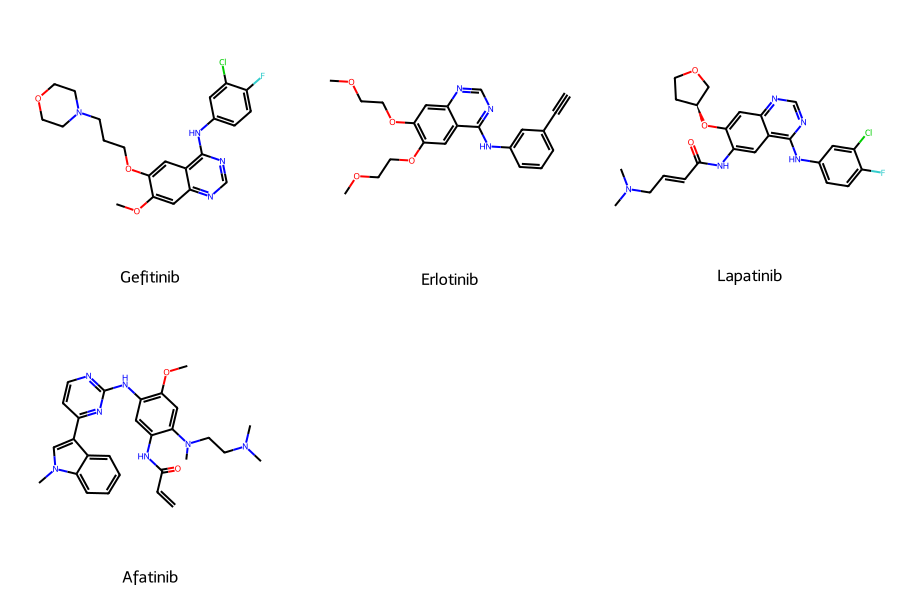

In [12]:

# Visualize the molecules in a grid
img = Draw.MolsToGridImage(
    filtered_molecules,
    legends=df['Name'].tolist(),  # Use molecule names as legends
    molsPerRow=3,                 # Number of molecules per row
    subImgSize=(300, 300)         # Size of each molecule image
)

# Display the image
img

In [13]:
df = pd.read_csv("data/CHEMBL25_activities_EGFR.csv")
df.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
2,6373,CHEMBL3678951,1.0,nM,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
3,2442,CHEMBL504034,40.0,nM,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
4,1084,CHEMBL158797,43000.0,nM,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532


In [14]:
df_actives = df[df['pIC50'] < 6.3]#sorting the actives
df_actives.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
4,1084,CHEMBL158797,43000.0,nM,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532
10,3047,CHEMBL591706,32120.0,nM,CCCCN(Cc1cccc(Cl)c1O)C(=O)Nc2ccccc2,4.493224
15,91,CHEMBL78150,460000.0,nM,CC(C)(C)c1cc(C=C(C#N)C#N)cc(c1O)C(C)(C)C,3.337242
16,3342,CHEMBL1241948,100000.0,nM,CC(C)n1nc(c2cccc(NS(=O)(=O)C)c2)c3c(N)ncnc13,4.000000
17,4864,CHEMBL3233765,3399.0,nM,CN1CCN(CC(=O)Nc2cc3c(Nc4ccc(F)c(Cl)c4)ncnc3s2)CC1,5.468649


In [15]:
df_inactives = df[df['pIC50'] >= 6.3]#sorting the inactives
df_inactives.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
2,6373,CHEMBL3678951,1.0,nM,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
3,2442,CHEMBL504034,40.0,nM,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
5,6596,CHEMBL4069003,3.0,nM,NP(=O)(OCCCOc1ccc2ncnc(Nc3cccc(Br)c3)c2c1)N(CC...,8.522879


In [16]:
smiles_active = df_actives["canonical_smiles"].tolist()
smiles_inactive = df_inactives["canonical_smiles"].tolist()

In [17]:
#maccs fingerprints
fingerprintsmaccs_active = []
fingerprintsmaccs_inactive = []

for smiles in smiles_active: 
    molecule = Chem.MolFromSmiles(smiles)
    fingerprintsmaccs_active.append(MACCSkeys.GenMACCSKeys(molecule))

for smiles in smiles_inactive:
    molecule = Chem.MolFromSmiles(smiles)
    fingerprintsmaccs_inactive.append(MACCSkeys.GenMACCSKeys(molecule))

In [18]:
# Combine fingerprints and labels
fps = fingerprintsmaccs_active + fingerprintsmaccs_inactive  # Feature vectors
y = [1] * len(fingerprintsmaccs_active) + [0] * len(fingerprintsmaccs_inactive)  # Labels

# Convert to PyTorch tensors
X = torch.tensor(fps, dtype=torch.float32)  # Features
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Labels (reshaped to (N, 1))

In [19]:
from sklearn.model_selection import train_test_split
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [20]:

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function
        x = torch.relu(self.fc2(x))  # Activation function
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [21]:
input_size = len(fps[0])  # Number of features (MACCS fingerprint bits)
hidden_size = 128         # Number of neurons in hidden layers
output_size = 1           # Binary classification (active/inactive)

model = SimpleNN(input_size, hidden_size, output_size)

In [22]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [23]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.6659
Epoch [10/20], Loss: 0.6396
Epoch [15/20], Loss: 0.6025
Epoch [20/20], Loss: 0.5614


In [24]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (y_pred == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')

Test Accuracy: 73.66%


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert PyTorch tensors to numpy arrays for Random Forest
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy().ravel()
y_test_np = y_test.numpy().ravel()

In [26]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234, max_features=100,n_jobs=-1)
rf_model.fit(X_train_np, y_train_np)

RandomForestClassifier(max_features=100, n_jobs=-1, random_state=1234)

In [27]:
y_pred_rf = rf_model.predict(X_test_np)
y_pred_rf[:10]

array([1., 0., 1., 1., 1., 1., 1., 0., 1., 1.], dtype=float32)

In [28]:
y_prob_rf=rf_model.predict_proba(X_test)
y_prob_rf[:10]

array([[0.47333333, 0.52666667],
       [0.655     , 0.345     ],
       [0.2       , 0.8       ],
       [0.05      , 0.95      ],
       [0.39383333, 0.60616667],
       [0.        , 1.        ],
       [0.01      , 0.99      ],
       [0.90916667, 0.09083333],
       [0.195     , 0.805     ],
       [0.24833333, 0.75166667]])

In [29]:
# Calculate accuracy and classification report
rf_accuracy = accuracy_score(y_test_np, y_pred_rf)
rf_classification_report = classification_report(y_test_np, y_pred_rf)

print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")
print("\nClassification Report:\n", rf_classification_report)

Random Forest Test Accuracy: 85.55%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       459
         1.0       0.84      0.80      0.82       323

    accuracy                           0.86       782
   macro avg       0.85      0.85      0.85       782
weighted avg       0.86      0.86      0.85       782



In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

# Neural Network: Calculate probabilities and AUC
with torch.no_grad():
    y_prob_nn = model(X_test).numpy()  # Get probabilities from the neural network

nn_auc = roc_auc_score(y_test_np, y_prob_nn)  # Calculate AUC for neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test_np, y_prob_nn)  # Calculate ROC for neural network


In [31]:
# Random Forest: Calculate probabilities and AUC
y_prob_rf = rf_model.predict_proba(X_test_np)[:, 1]  # Probabilities for class 1 (active)

rf_auc = roc_auc_score(y_test_np, y_prob_rf)  # Calculate AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_np, y_prob_rf)  # Calculate ROC for Random Forest


/var/folders/ts/vqxzv1017qb02q48zs_jkpch0000gn/T/ipykernel_13964/3513021375.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='black')  # Random baseline


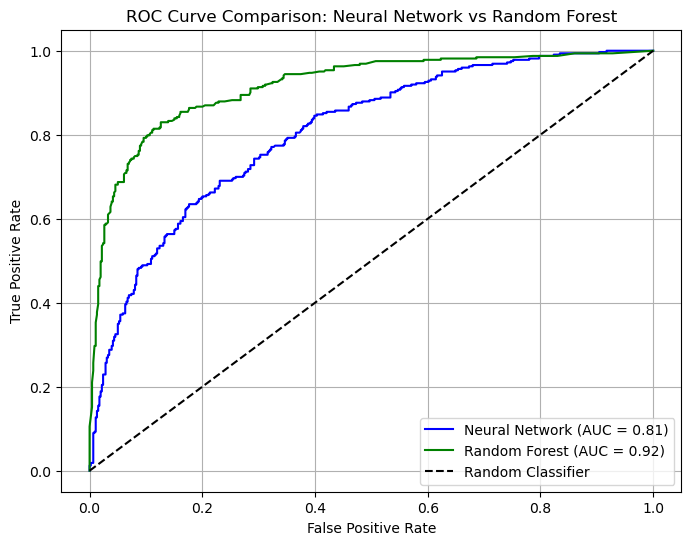

In [32]:
# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_auc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='black')  # Random baseline

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Neural Network vs Random Forest')
plt.legend()
plt.grid()
plt.show()


In [33]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf.get_n_splits(fps, y)

5

In [34]:


# DataFrame to store results
dataFrames = pd.DataFrame(columns=["Accuracy", "AUC", "Sensitivity", "Specificity"])
accu = []
sensit = []
specifi = []
aucList = []
models = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X.numpy(), y.numpy().ravel()):
    # Split the data
    X_train, X_test = X.numpy()[train_index], X.numpy()[test_index]
    y_train, y_test = y.numpy().ravel()[train_index], y.numpy().ravel()[test_index]
    
    # Train the Random Forest model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Sensitivity (True Positive Rate) and Specificity (1 - False Positive Rate)
    sensitivity = tpr[1] if len(tpr) > 1 else 0  # Avoid index error if tpr has only one value
    specificity = 1 - fpr[1] if len(fpr) > 1 else 0
    
    # Store metrics
    accu.append(accuracy)
    aucList.append(roc_auc)
    sensit.append(sensitivity)
    specifi.append(specificity)
    models.append(rf_model)
    dataFrames.loc[len(dataFrames)] = [accuracy, roc_auc, sensitivity, specificity]

# Calculate and display the final DataFrame
print(dataFrames)


   Accuracy       AUC  Sensitivity  Specificity
0  0.832481  0.894028     0.126844     0.997743
1  0.839949  0.896331     0.117994     0.997738
2  0.819462  0.877793     0.106509     1.000000
3  0.838668  0.897782     0.136095     0.995485
4  0.829706  0.890856     0.079882     0.995485


In [35]:
topredict = pd.read_csv("data/test_compounds_EGFR.csv")
topredict.head()

,Unnamed: 0,chembl_id,canonical_smiles
0,1927,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1
1,212,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl
2,3089,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...
3,3126,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...
4,3125,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1


In [36]:
# Generate RDKit molecules and MACCS fingerprints
molecules2 = [Chem.MolFromSmiles(mol) for mol in topredict["canonical_smiles"]]
fingerprints_maccs = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules2]  # MACCS fingerprints

# Predict using the trained Random Forest model
predict_maccs = rf_model.predict(fingerprints_maccs)

# Filter and collect predicted active compounds
final = [mol for mol, pred in zip(molecules2, predict_maccs) if pred == 1]

# Output the number of active compounds
print(f"Number of predicted active compounds: {len(final)}")

Number of predicted active compounds: 395


In [37]:
def apply_lipinski_filter(molecules):
    filtered_molecules = []
    for mol in molecules:
        if Descriptors.NumHAcceptors(mol) <= 10 and \
           Descriptors.NumHDonors(mol) <= 5 and \
           Descriptors.MolWt(mol) <= 500 and \
           Descriptors.MolLogP(mol) <= 5:
            filtered_molecules.append(mol)
    return filtered_molecules

# Apply the Lipinski filter
final2 = apply_lipinski_filter(final)

print(f"Number of molecules passing Lipinski's Rule of Five: {len(final2)}")


Number of molecules passing Lipinski's Rule of Five: 272


In [38]:
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import numpy as np
# Number of fingerprints
num_fps = len(fingerprints_maccs)

# Calculate the pairwise dissimilarity matrix
dissim_matrix = np.zeros((num_fps, num_fps))
for i in range(num_fps):
    for j in range(i, num_fps):
        sim = DataStructs.FingerprintSimilarity(fingerprints_maccs[i], fingerprints_maccs[j])  # MACCS similarity
        dissim = 1 - sim  # Dissimilarity
        dissim_matrix[i][j] = dissim
        dissim_matrix[j][i] = dissim

# Display the shape of the dissimilarity matrix
print("Dissimilarity Matrix Shape:", dissim_matrix.shape)

Dissimilarity Matrix Shape: (1051, 1051)


In [39]:
# Extract upper triangular matrix as a flat list for Butina clustering
distances = dissim_matrix[np.triu_indices(num_fps, k=1)].tolist()

# Perform Butina clustering
cutoff = 0.4272# Similarity cutoff (1 - cutoff = minimum similarity for clustering)
clusters = Butina.ClusterData(distances, num_fps, cutoff, isDistData=True)

# Output the clusters
print(f"Number of clusters: {len(clusters)}")
print("Clusters:", clusters)

Number of clusters: 23
Clusters: ((950, 0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 42, 43, 47, 49, 50, 51, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 81, 88, 89, 90, 91, 92, 94, 95, 97, 98, 99, 100, 104, 105, 108, 109, 110, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 135, 137, 139, 141, 142, 143, 144, 147, 148, 149, 150, 151, 153, 154, 156, 160, 164, 167, 173, 174, 177, 178, 182, 185, 187, 193, 195, 198, 199, 203, 205, 208, 209, 210, 211, 212, 213, 215, 216, 218, 219, 221, 224, 231, 233, 237, 239, 241, 242, 243, 245, 246, 247, 248, 249, 250, 256, 260, 265, 269, 271, 273, 274, 277, 279, 283, 286, 288, 296, 301, 307, 312, 324, 327, 328, 330, 335, 337, 338, 341, 344, 345, 350, 351, 352, 359, 361, 362, 364, 365, 366, 367, 372, 380, 383, 398, 405, 414, 419, 420, 422, 424, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 439, 440

In [40]:
print(f"Number of molecules in final2: {len(final2)}")
print(f"Clusters: {clusters}")


Number of molecules in final2: 272
Clusters: ((950, 0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 42, 43, 47, 49, 50, 51, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 81, 88, 89, 90, 91, 92, 94, 95, 97, 98, 99, 100, 104, 105, 108, 109, 110, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 135, 137, 139, 141, 142, 143, 144, 147, 148, 149, 150, 151, 153, 154, 156, 160, 164, 167, 173, 174, 177, 178, 182, 185, 187, 193, 195, 198, 199, 203, 205, 208, 209, 210, 211, 212, 213, 215, 216, 218, 219, 221, 224, 231, 233, 237, 239, 241, 242, 243, 245, 246, 247, 248, 249, 250, 256, 260, 265, 269, 271, 273, 274, 277, 279, 283, 286, 288, 296, 301, 307, 312, 324, 327, 328, 330, 335, 337, 338, 341, 344, 345, 350, 351, 352, 359, 361, 362, 364, 365, 366, 367, 372, 380, 383, 398, 405, 414, 419, 420, 422, 424, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 4

In [41]:
# Generate fingerprints for `final2` (filtered molecules)
fingerprints_final2 = [MACCSkeys.GenMACCSKeys(mol) for mol in final2]

# Map indices from `final2` to corresponding SMILES
final2_smiles = [Chem.MolToSmiles(mol) for mol in final2]

# Select the first molecule from each cluster
first_elems = []
first_smiles = []

for cluster in clusters:
    for member_idx in cluster:
        if member_idx < len(final2):  # Ensure index is within bounds
            first_elems.append(final2[member_idx])
            first_smiles.append(final2_smiles[member_idx])
            break  # Take the first molecule from the cluster and move to the next cluster

# Ensure the number of selected molecules matches
print(f"Number of selected cluster representatives: {len(first_elems)}")


Number of selected cluster representatives: 11


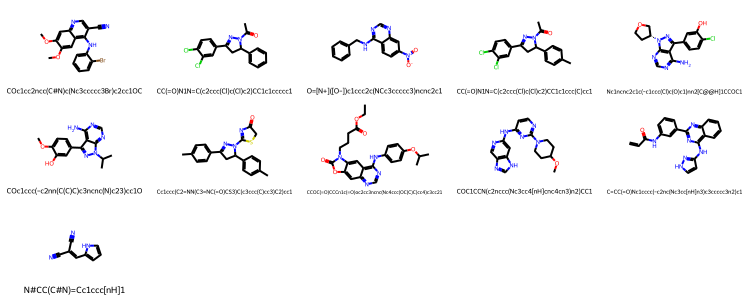

In [42]:
# Draw molecules with SMILES as legends
img = Draw.MolsToGridImage(
    first_elems,
    legends=first_smiles,  # Use SMILES as legends
    molsPerRow=5,
    subImgSize=(150, 100)
)

# Display the grid image
img

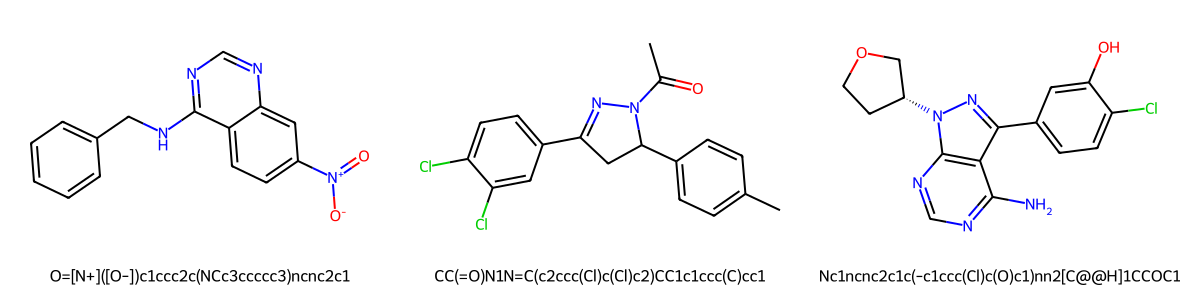

In [43]:
# Extract SMILES for the selected compounds
selected_smiles = [Chem.MolToSmiles(first_elems[i]) for i in [2, 3, 4]]

# Select the specific compounds
three_compounds = [first_elems[i] for i in [2, 3, 4]]

# Draw the molecules with SMILES as legends
img = Draw.MolsToGridImage(
    three_compounds,
    legends=selected_smiles,  # Use SMILES as legends
    molsPerRow=3,             # Set number of molecules per row
    subImgSize=(400, 300))     # Larger sub-image size for higher resolution)

# Display the image
img


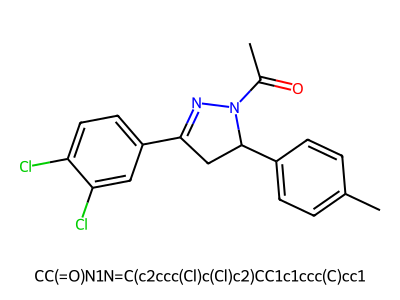

In [44]:
# Select the middle compound and its SMILES
final = first_elems[3]
final_smiles = Chem.MolToSmiles(final)

# Draw the molecule with its SMILES as a legend
img = Draw.MolsToGridImage(
    [final],
    legends=[final_smiles],
    molsPerRow=1,
    subImgSize=(400, 300)
)

# Display the image
img


In [45]:
final_smiles

'CC(=O)N1N=C(c2ccc(Cl)c(Cl)c2)CC1c1ccc(C)cc1'